In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

# ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
# check proper behaviour
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def flatten(x):
    return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), #7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), #4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [2.03919140625, tensor(0.2857)]
valid: [1.0928041015625, tensor(0.5957)]
CPU times: user 7.16 s, sys: 4.2 s, total: 11.4 s
Wall time: 3.81 s


# CUDA

In [16]:
# flexible way
device = torch.device('cuda', 0)

In [17]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device=device
    def begin_fit(self):
        self.model.to(device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [18]:
# less flexible
torch.cuda.set_device(device)

In [19]:
#export
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [1.76244390625, tensor(0.3957, device='cuda:0')]
valid: [0.425653564453125, tensor(0.8768, device='cuda:0')]
train: [0.3301805859375, tensor(0.8999, device='cuda:0')]
valid: [0.205518115234375, tensor(0.9406, device='cuda:0')]
train: [0.1789709375, tensor(0.9461, device='cuda:0')]
valid: [0.12945318603515624, tensor(0.9616, device='cuda:0')]
CPU times: user 5.43 s, sys: 1.59 s, total: 7.02 s
Wall time: 6.48 s


## Refactor model

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [25]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm):
        self.tfm = tfm
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,)+size))
    return _inner

In [26]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [27]:
nfs = [8,16,32,32]

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [29]:
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [30]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [31]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
run.fit(3, learn)

train: [2.028619375, tensor(0.3043, device='cuda:0')]
valid: [0.9074703125, tensor(0.7489, device='cuda:0')]
train: [0.4816620703125, tensor(0.8484, device='cuda:0')]
valid: [0.223121484375, tensor(0.9333, device='cuda:0')]
train: [0.20306986328125, tensor(0.9377, device='cuda:0')]
valid: [0.222684912109375, tensor(0.9346, device='cuda:0')]


## Hooks

### Manual insertion

In [34]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [35]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [36]:
run.fit(2, learn)

train: [2.3118978125, tensor(0.1594, device='cuda:0')]
valid: [2.2819130859375, tensor(0.1090, device='cuda:0')]
train: [1.36062875, tensor(0.5468, device='cuda:0')]
valid: [0.3942760986328125, tensor(0.8842, device='cuda:0')]


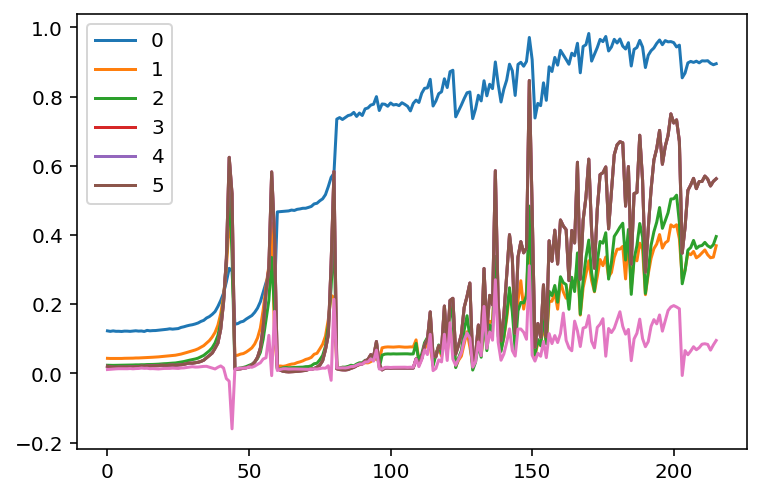

In [37]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(6));

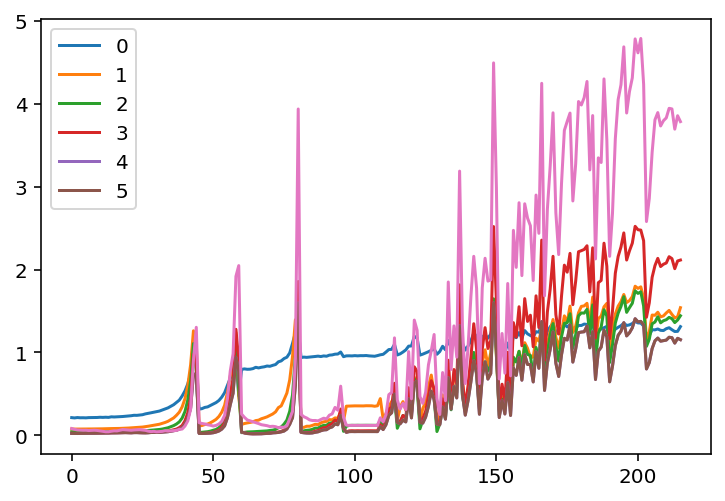

In [38]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6));

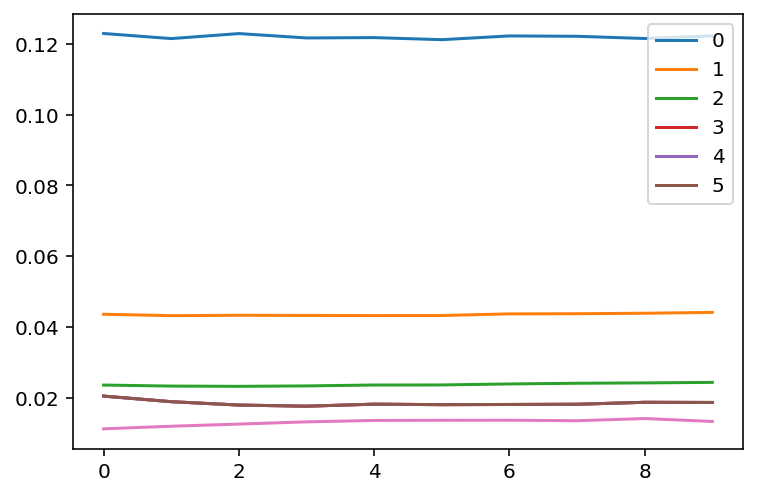

In [39]:
for l in model.act_means:
    plt.plot(l[:10])
plt.legend(range(6));

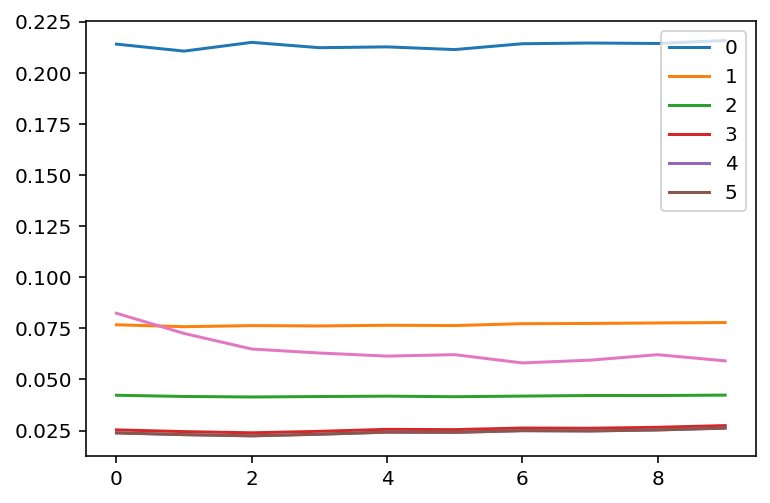

In [40]:
for l in model.act_stds:
    plt.plot(l[:10])
plt.legend(range(6));

## Pytorch hooks

In [41]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [42]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [43]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [44]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [45]:
run.fit(1, learn)

train: [2.26567875, tensor(0.1489, device='cuda:0')]
valid: [2.01618671875, tensor(0.2618, device='cuda:0')]


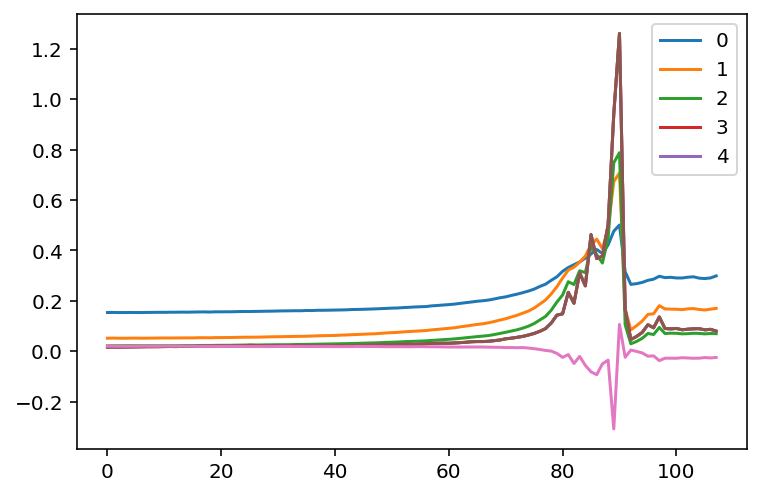

In [46]:
for o in act_means:
    plt.plot(o)
plt.legend(range(5));

## Hook class

In [47]:
#export
def children(m):
    return list(m.children())

class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [48]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [49]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [50]:
run.fit(1, learn)

train: [1.73556078125, tensor(0.4253, device='cuda:0')]
valid: [0.901412890625, tensor(0.7193, device='cuda:0')]


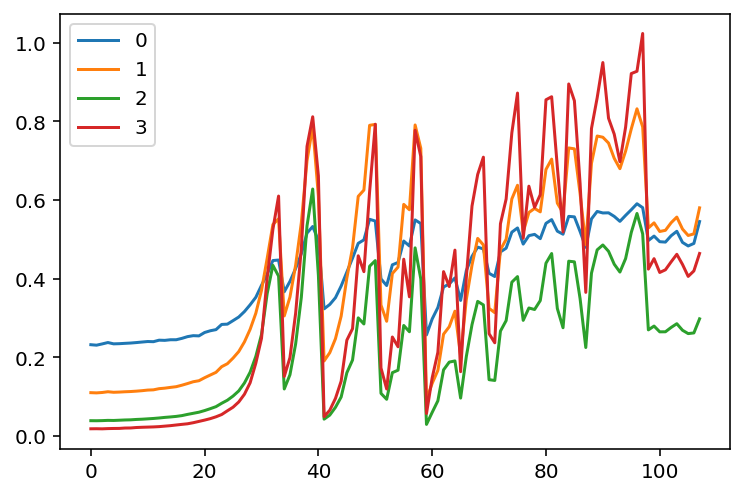

In [51]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A hooks class

In [52]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self):
        return len(self.items)
    def __iter__(self):
        return iter(self.items)
    def __setitem__(self, i, o):
        self.items[i] = o
    def __delitem__(self, i):
        del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__}({len(self)} items)\n{self.items[:10]}'
        if len(self)>10:
            res = res[:-1] + '...]'
        return res

In [53]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
    def __getitem__(self, idx):
        try:
            return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx, self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self):
        return len(self.items)
    def __iter__(self):
        return iter(self.items)
    def __setitem__(self, i, o):
        self.items[i] = o
    def __delitem__(self, i):
        del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__}({len(self)} items)\n{self.items[:10]}'
        if len(self)>10:
            res = res[:-1] + '...]'
        return res

In [54]:
ListContainer(range(10))

ListContainer(10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [55]:
ListContainer(range(100))

ListContainer(100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [56]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True, False]]

([1, 2], [8])

In [57]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): #start with block
        return self
    def __exit__(self, *args): #leave with block
        self.remove()
    def __del__(self):
        self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self:
            h.remove()

In [58]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [59]:
hooks = Hooks(model, append_stats)

In [60]:
hooks

Hooks(7 items)
[<__main__.Hook object at 0x7f1898429d50>, <__main__.Hook object at 0x7f1898429c50>, <__main__.Hook object at 0x7f1898429c10>, <__main__.Hook object at 0x7f1898429d10>, <__main__.Hook object at 0x7f1898429690>, <__main__.Hook object at 0x7f1898311650>, <__main__.Hook object at 0x7f1898311c50>]

In [61]:
hooks.remove()

In [62]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [63]:
x.mean(), x.std()

(tensor(-0.0031, device='cuda:0'), tensor(0.9948, device='cuda:0'))

In [64]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1591, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2598, device='cuda:0', grad_fn=<StdBackward0>))

In [65]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [66]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4738, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9183, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.89972765625, tensor(0.3492, device='cuda:0')]
valid: [0.80329306640625, tensor(0.7198, device='cuda:0')]
train: [0.4341971484375, tensor(0.8588, device='cuda:0')]
valid: [0.236211279296875, tensor(0.9270, device='cuda:0')]


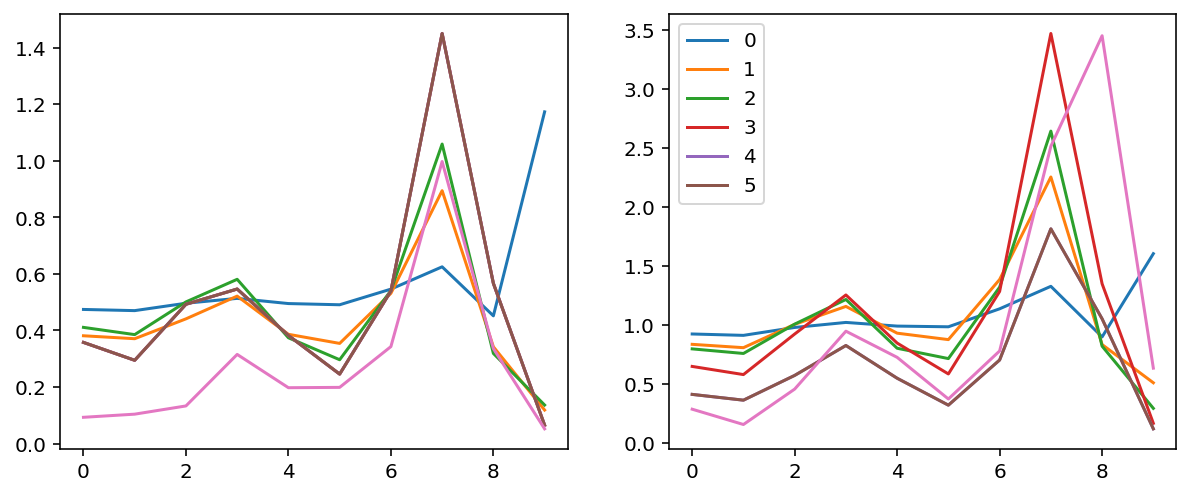

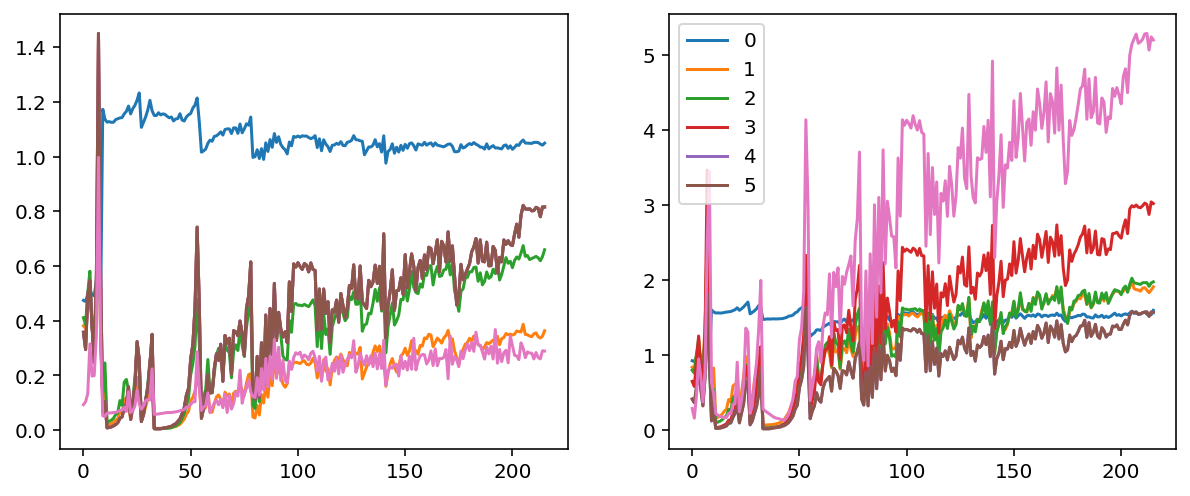

In [67]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other statistics

In [68]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, 0, 10)) #histc is only on cpu

In [69]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [70]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [71]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.1643175, tensor(0.6042, device='cuda:0')]
valid: [0.2084427490234375, tensor(0.9346, device='cuda:0')]


In [72]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

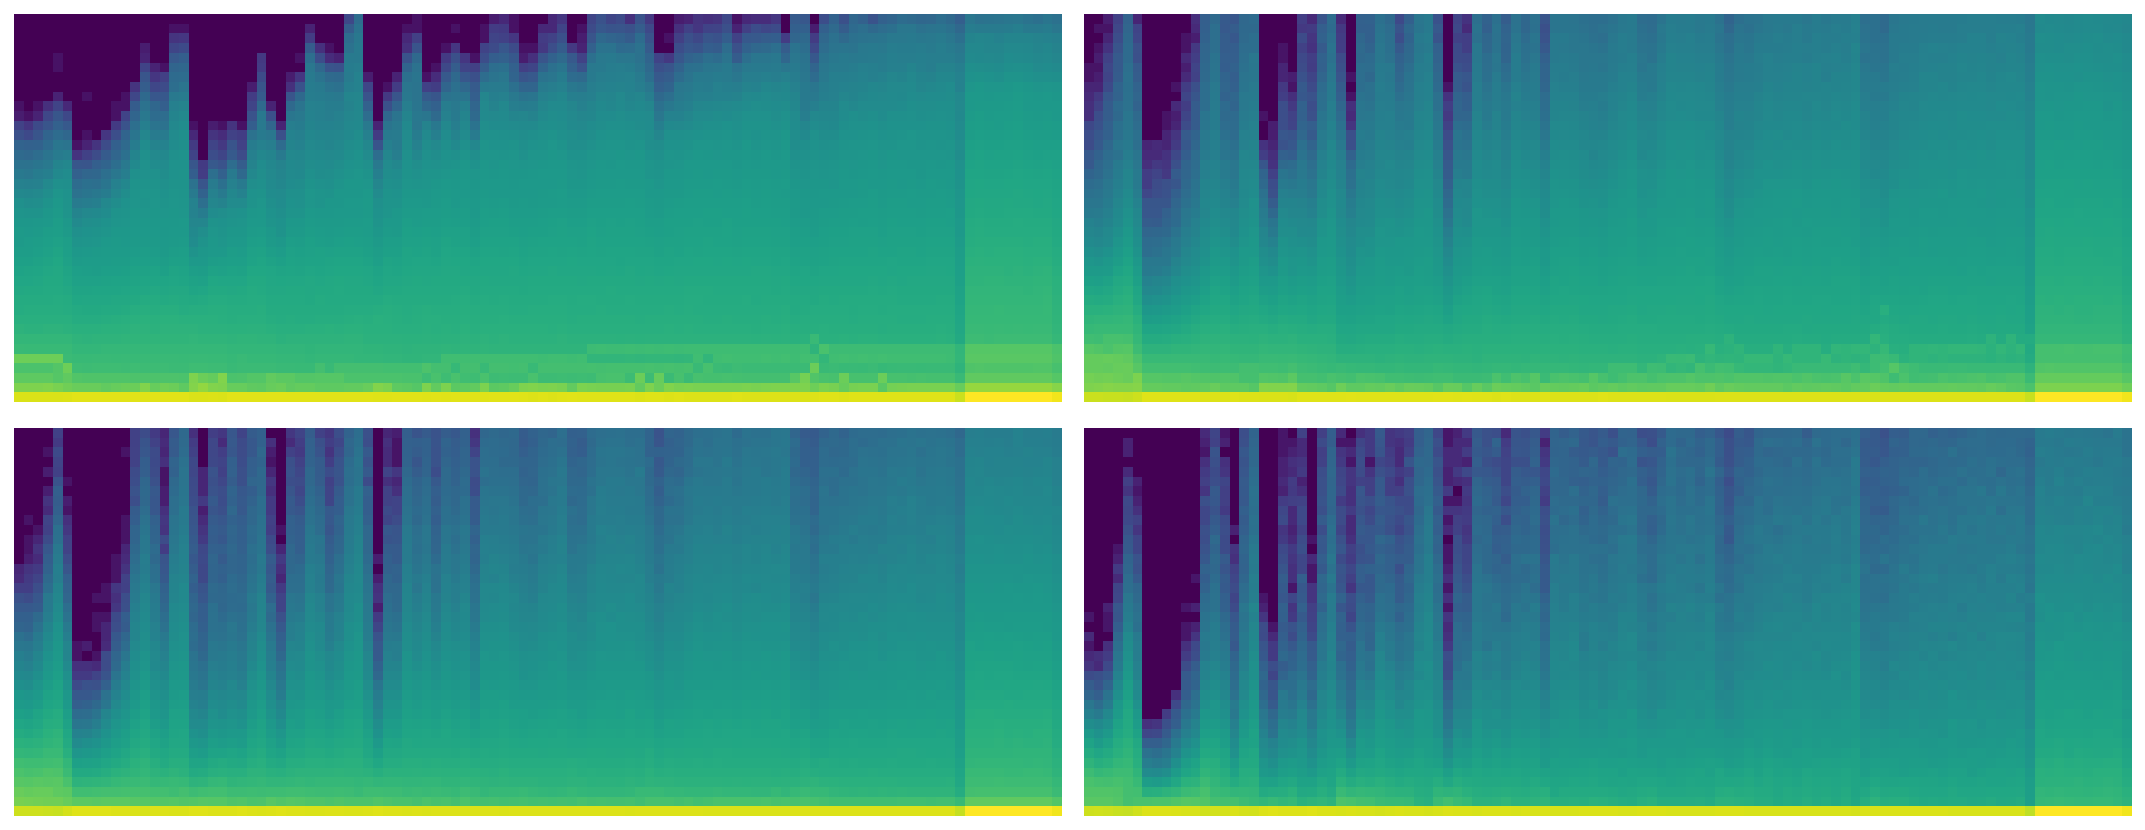

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [74]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

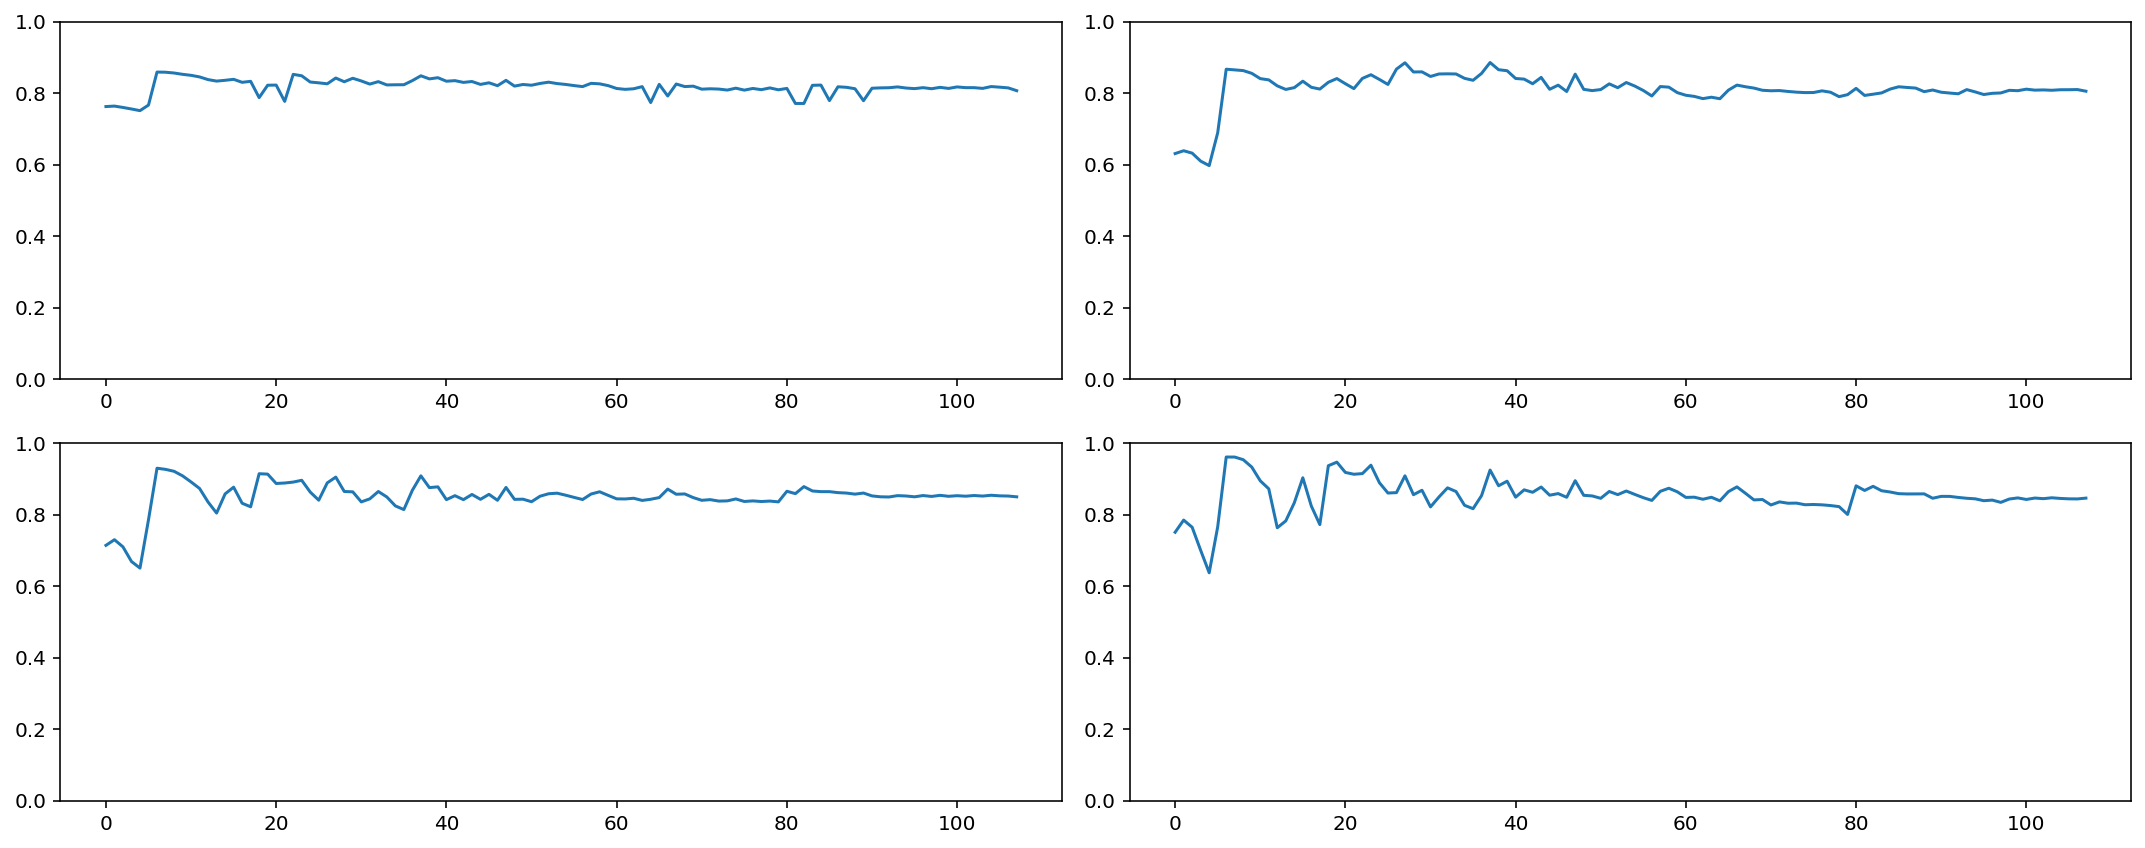

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Generalized RELU

In [76]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [77]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7))

In [78]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5464327734375, tensor(0.8263, device='cuda:0')]
valid: [0.1533041748046875, tensor(0.9553, device='cuda:0')]


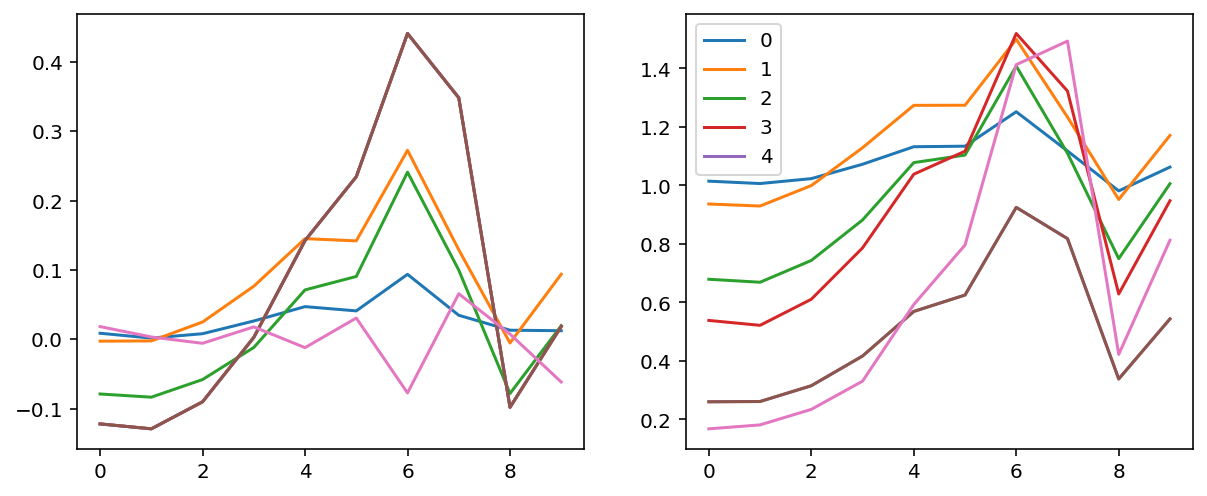

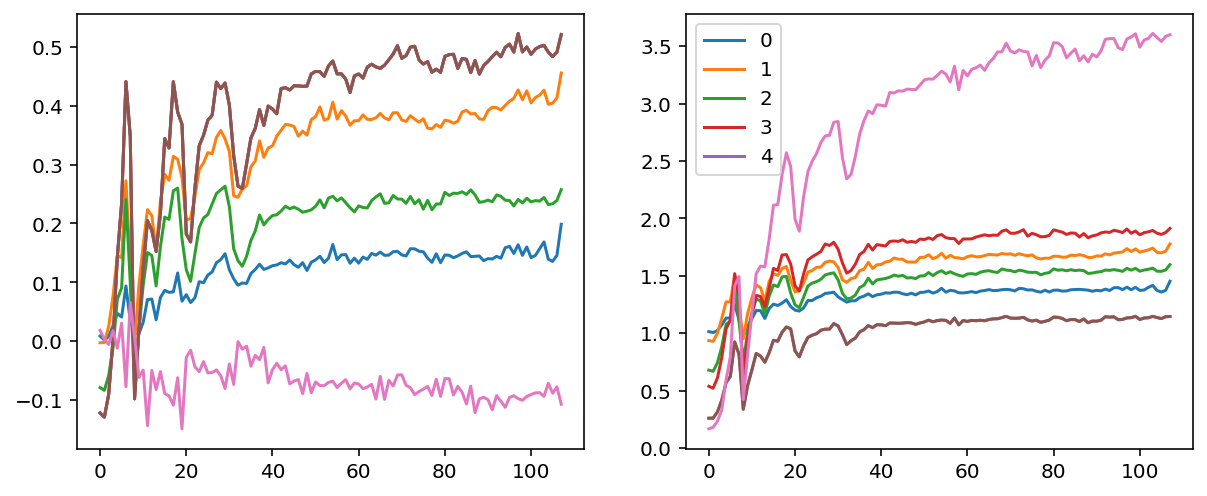

In [79]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

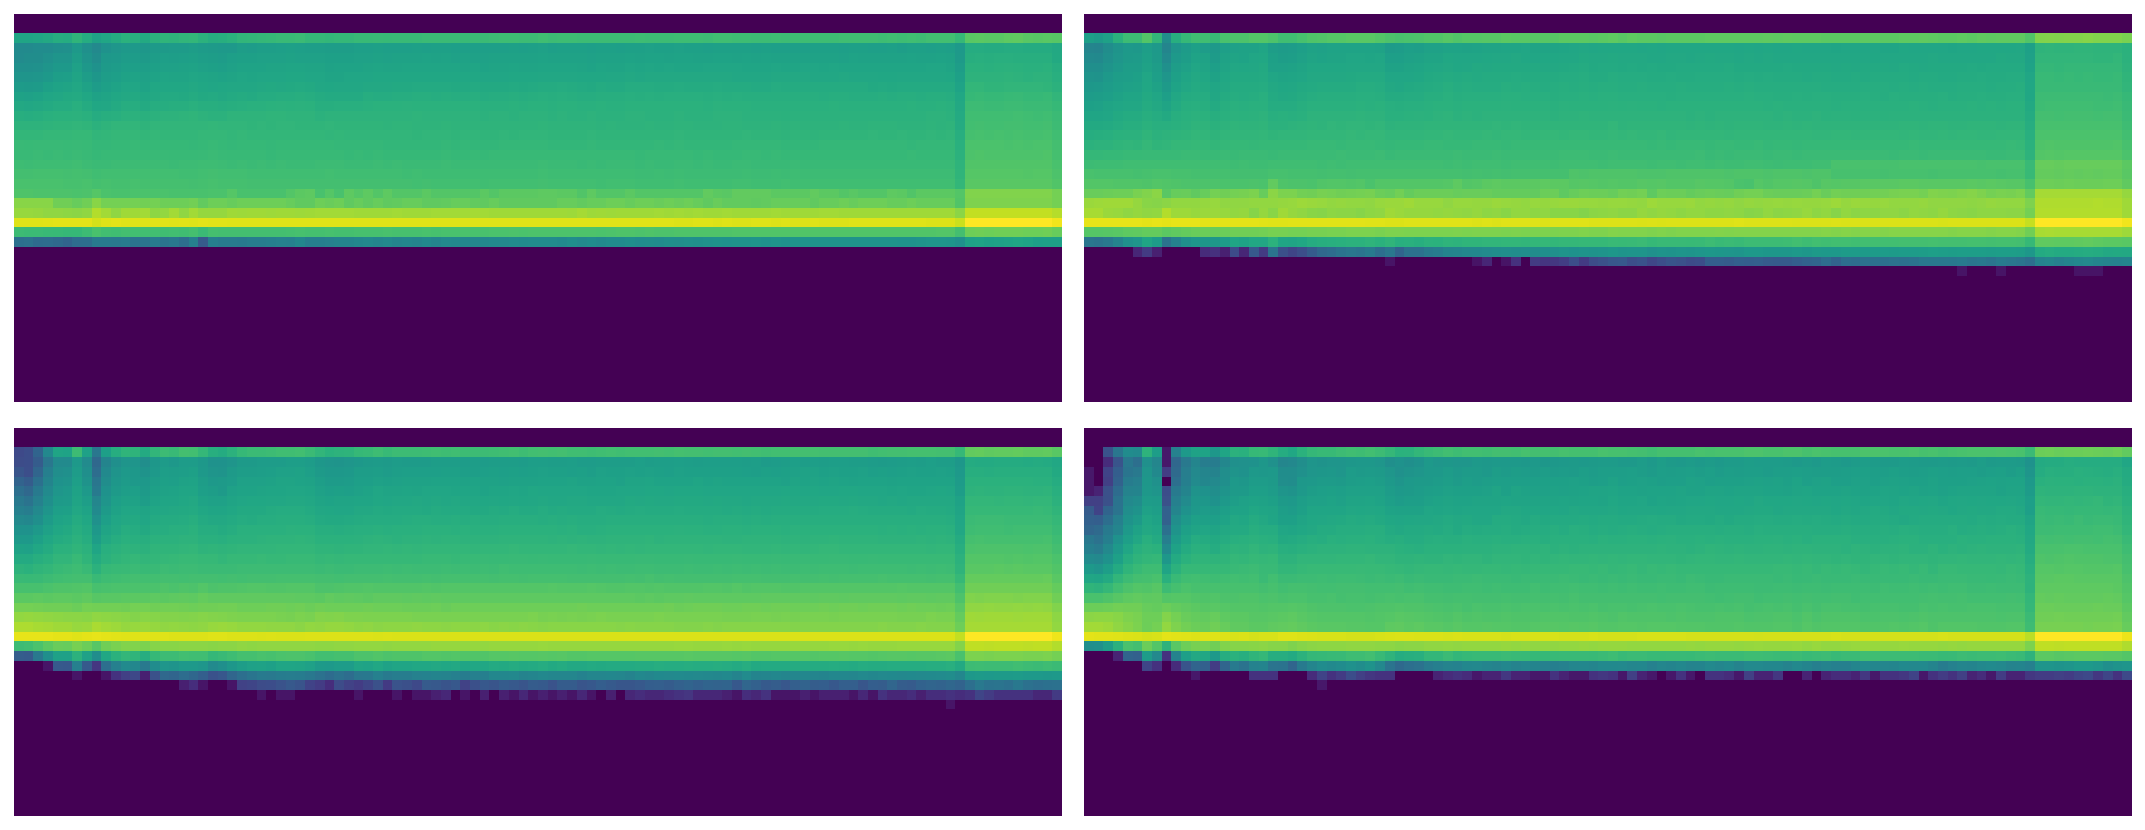

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [81]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

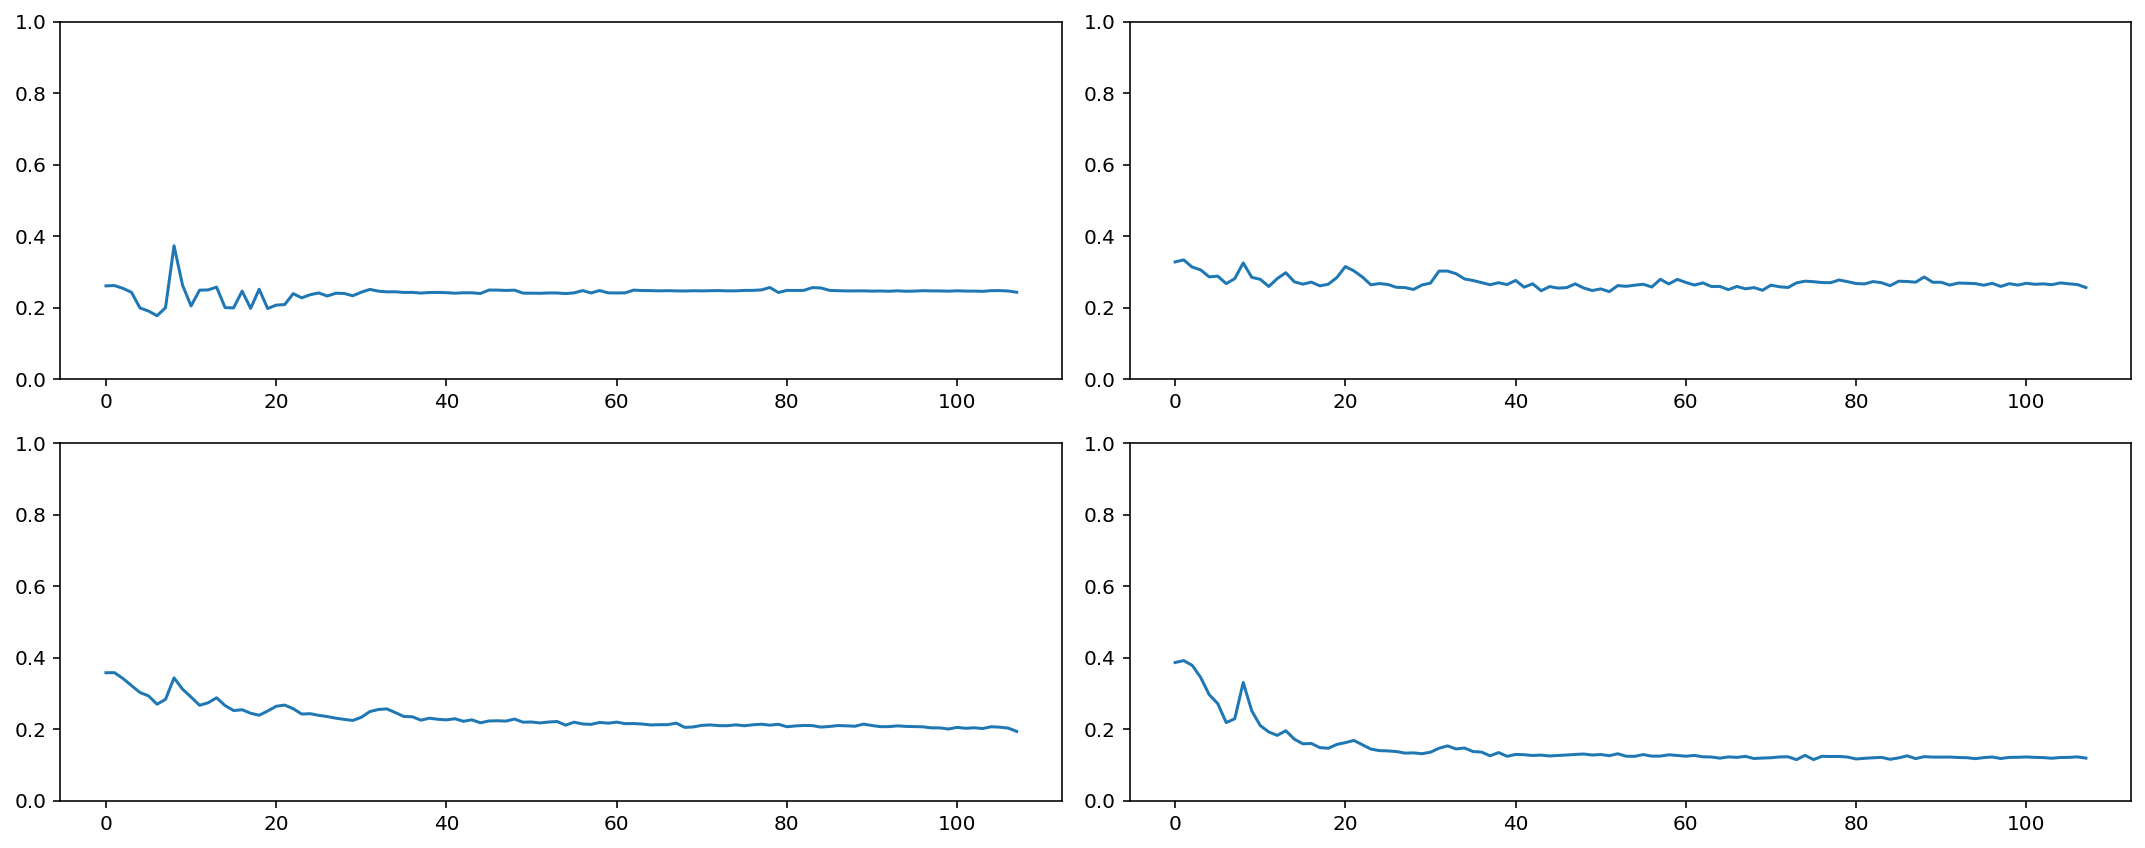

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [83]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [84]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [85]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [86]:
run.fit(8, learn)

train: [1.11020453125, tensor(0.6526, device='cuda:0')]
valid: [0.350860107421875, tensor(0.8897, device='cuda:0')]
train: [0.3310391015625, tensor(0.9011, device='cuda:0')]
valid: [0.16377889404296875, tensor(0.9497, device='cuda:0')]
train: [0.31403607421875, tensor(0.9085, device='cuda:0')]
valid: [0.1402255859375, tensor(0.9563, device='cuda:0')]
train: [0.1232037109375, tensor(0.9626, device='cuda:0')]
valid: [0.09875772705078124, tensor(0.9715, device='cuda:0')]
train: [0.093490751953125, tensor(0.9712, device='cuda:0')]
valid: [0.08680426025390625, tensor(0.9747, device='cuda:0')]
train: [0.0581582958984375, tensor(0.9817, device='cuda:0')]
valid: [0.06671381225585937, tensor(0.9808, device='cuda:0')]
train: [0.0437246044921875, tensor(0.9864, device='cuda:0')]
valid: [0.05974840087890625, tensor(0.9836, device='cuda:0')]
train: [0.035792236328125, tensor(0.9896, device='cuda:0')]
valid: [0.06092593994140625, tensor(0.9837, device='cuda:0')]


In [87]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs = cbfs+[partial(ParamScheduler, 'lr', sched)])

In [88]:
run.fit(8, learn)

train: [0.999455390625, tensor(0.6783, device='cuda:0')]
valid: [0.316942919921875, tensor(0.9070, device='cuda:0')]
train: [0.3168926171875, tensor(0.9030, device='cuda:0')]
valid: [0.588264697265625, tensor(0.8525, device='cuda:0')]
train: [0.833097265625, tensor(0.7747, device='cuda:0')]
valid: [1.931843359375, tensor(0.3108, device='cuda:0')]
train: [1.9977115625, tensor(0.2785, device='cuda:0')]
valid: [1.10445185546875, tensor(0.6254, device='cuda:0')]
train: [0.568343203125, tensor(0.8142, device='cuda:0')]
valid: [0.2471617431640625, tensor(0.9239, device='cuda:0')]
train: [0.214237890625, tensor(0.9333, device='cuda:0')]
valid: [0.202267626953125, tensor(0.9376, device='cuda:0')]
train: [0.138315712890625, tensor(0.9578, device='cuda:0')]
valid: [0.1231455810546875, tensor(0.9667, device='cuda:0')]
train: [0.115483681640625, tensor(0.9651, device='cuda:0')]
valid: [0.11302239990234375, tensor(0.9687, device='cuda:0')]


# Export

In [89]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()